# IMAGE CLASSIFICATION WITH TRANSFORMERS (BEANS LEAF DISEASE CLASSIFICATION) ** WITH NO LEAF DETECTION

# 1.0 Import Required Liberies

In [35]:
import os
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from datasets import DatasetDict, Dataset, Features, ClassLabel, Image
import matplotlib.pyplot as plt
from transformers import Trainer, TrainerCallback, ViTForImageClassification
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
import seaborn as sns
from transformers import ViTImageProcessor
import pandas as pd
from transformers import TrainingArguments


## 2.0 Data Understanding

In [7]:


# Set constants
BATCH_SIZE = 1
IMAGE_SIZE = 224
NUM_CLASSES = 4  # Adjust based on your dataset

# Define transformations (without data augmentation)
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to tensors
])

# Load datasets from directories
train_ds = datasets.ImageFolder(root="train_3", transform=transform)
val_ds = datasets.ImageFolder(root="val_3", transform=transform)
test_ds = datasets.ImageFolder(root="test_3", transform=transform)

def dataset_to_list(dataset):
    """
    Convert a PyTorch dataset to a list of dictionaries containing images and labels.
    """
    data = []
    for img, label in dataset:
        img = img.permute(1, 2, 0).numpy()  # Change shape to [height, width, channels]
        img = (img * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8
        data.append({
            'image': img,   # Keep as NumPy array in uint8 format
            'labels': int(label)  # Convert label to scalar
        })
    return data

# Define features for the Hugging Face dataset
features = Features({
    'image': Image(),  # Image feature from Hugging Face
    'labels': ClassLabel(num_classes=NUM_CLASSES)  # Class label feature with NUM_CLASSES
})

# Convert datasets to lists of dictionaries
train_data = dataset_to_list(train_ds)
val_data = dataset_to_list(val_ds)
test_data = dataset_to_list(test_ds)

# Create Hugging Face datasets
train_hf_ds = Dataset.from_dict({
    'image': [item['image'] for item in train_data], 
    'labels': [item['labels'] for item in train_data]
}, features=features)

val_hf_ds = Dataset.from_dict({
    'image': [item['image'] for item in val_data], 
    'labels': [item['labels'] for item in val_data]
}, features=features)

test_hf_ds = Dataset.from_dict({
    'image': [item['image'] for item in test_data], 
    'labels': [item['labels'] for item in test_data]
}, features=features)

# Create a DatasetDict
ds = DatasetDict({
    'train': train_hf_ds,
    'validation': val_hf_ds,
    'test': test_hf_ds
})

# Display details about the DatasetDict
print(ds)


DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 1406
    })
    validation: Dataset({
        features: ['image', 'labels'],
        num_rows: 177
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 171
    })
})


### Print batch size and labels

In [8]:
# Print class names and their corresponding indices
labels = ds['train'].features['labels']
print(labels)
print("Class names and indices:", train_ds.class_to_idx)

ClassLabel(names=['0', '1', '2', '3'], id=None)
Class names and indices: {'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2, 'no_leaf': 3}


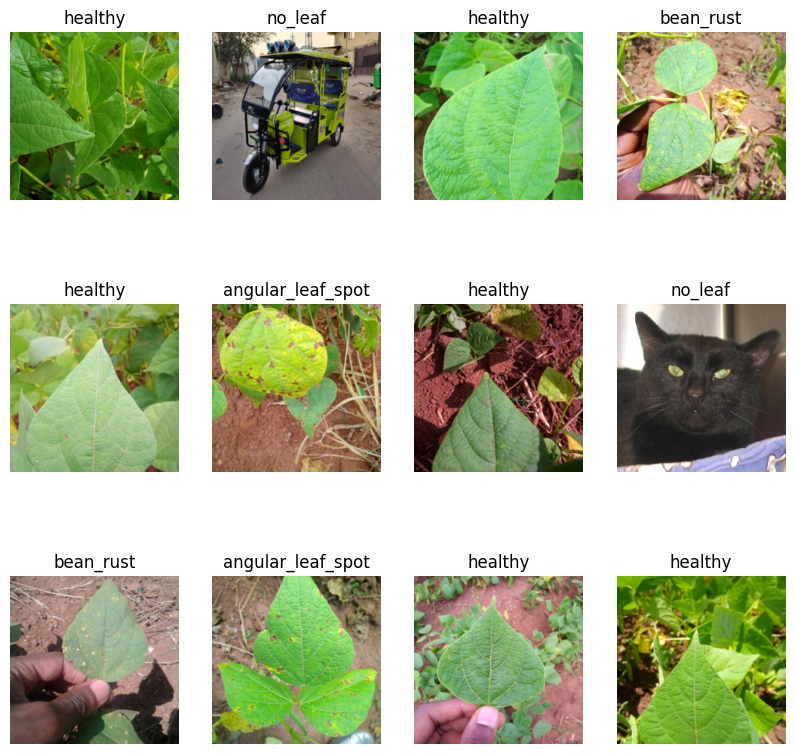

In [9]:

# Create DataLoader for the training dataset
train_loader = DataLoader(val_ds, batch_size=12, shuffle=True)  # Load 12 images for visualization

# Get class names from ImageFolder
class_names = train_ds.classes

# Plot images in a 3x4 grid
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_loader:
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        # Convert image to correct shape and scale to [0, 255]
        img = image_batch[i].permute(1, 2, 0).numpy() * 255  # Scale pixel values to [0, 255]
        plt.imshow(img.astype("uint8"))  # Convert to uint8 for display
        plt.title(class_names[labels_batch[i].item()])  # Get class name
        plt.axis("off")
    break  # Only plot one batch

plt.show()

# Create dataset dictionary
#dataset_dict = {
    'train': {
        'features': ['image_file_path', 'image', 'labels'],
        'num_rows': train_ds.cardinality().numpy()
    },
    'validation': {
        'features': ['image_file_path', 'image', 'labels'],
        'num_rows': val_ds.cardinality().numpy()
    },
    'test': {
        'features': ['image_file_path', 'image', 'labels'],
        'num_rows': test_ds.cardinality().numpy()
    }
}

#print(dataset_dict)

from datasets import Dataset, Features, ClassLabel, Image
import tensorflow as tf
import numpy as np

# Convert TensorFlow dataset to a list of dictionaries
def tf_dataset_to_list(tf_dataset):
    data = []
    for batch in tf_dataset:
        images, labels = batch
        for img, label in zip(images, labels):
            # Ensure the image is in the right format (H, W, C) and convert to uint8
            img = img.numpy().astype(np.uint8) if tf.is_tensor(img) else img.astype(np.uint8)
            data.append({
                'image': img,  # Keep as NumPy array in uint8 format
                'label': int(label.numpy())  # Convert to scalar
            })
    return data

# Define features for the Hugging Face dataset
features = Features({
    'image': Image(),  # Image feature from Hugging Face
    'label': ClassLabel(num_classes=NUM_CLASSES)  # Class label feature with NUM_CLASSES
})

# Convert datasets
train_data = tf_dataset_to_list(train_ds)
val_data = tf_dataset_to_list(val_ds)
test_data = tf_dataset_to_list(test_ds)

# Create Hugging Face datasets
train_hf_ds = Dataset.from_dict({'image': [item['image'] for item in train_data], 'label': [item['label'] for item in train_data]}, features=features)
val_hf_ds = Dataset.from_dict({'image': [item['image'] for item in val_data], 'label': [item['label'] for item in val_data]}, features=features)
test_hf_ds = Dataset.from_dict({'image': [item['image'] for item in test_data], 'label': [item['label'] for item in test_data]}, features=features)

# Display details about the datasets
print(train_hf_ds)
print(val_hf_ds)
print(test_hf_ds)


!pip install datasets
*italicised text*

# 3.0 DATA PREPARATION

In [10]:
# Download Vision tranformer Beans Disease Classification Model

model_name_or_path = 'nateraw/vit-base-beans'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)



def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = processor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

In [11]:
# Data Preparation with Data Argumentation


# Define augmentations
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),    # Random horizontal flip
    transforms.RandomRotation(15),        # Random rotation within 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color adjustments
])

# Transform and Argument the Dataset

def transform(example_batch):
    # Apply augmentations to each image in the batch
    augmented_images = [augmentation(x) for x in example_batch['image']]

    # Convert augmented images to pixel values
    inputs = processor(augmented_images, return_tensors='pt')

    # Include the labels in the output
    inputs['labels'] = example_batch['labels']
    return inputs

In [12]:
prepared_ds = ds.with_transform(transform)
prepared_ds

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 1406
    })
    validation: Dataset({
        features: ['image', 'labels'],
        num_rows: 177
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 171
    })
})

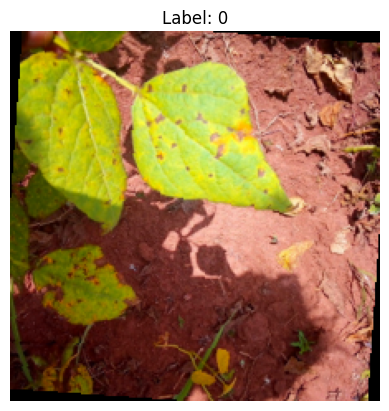

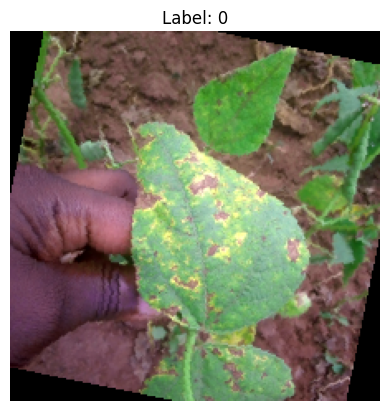

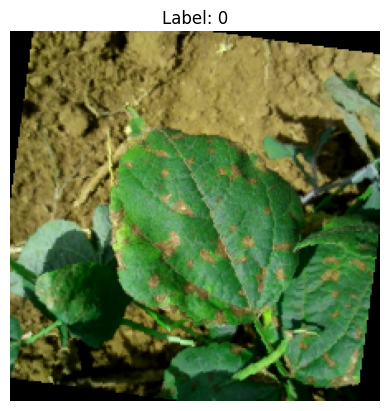

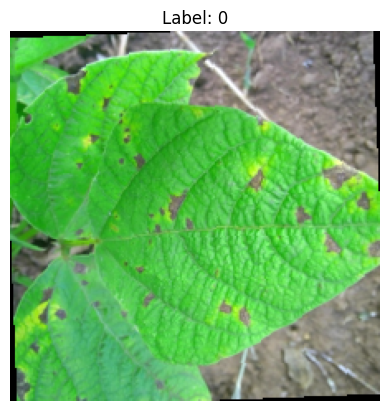

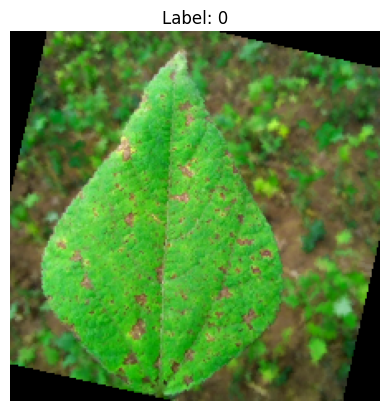

In [13]:


# Function to display a few sample images from the specified dataset split
def display_sample_images(dataset, split='train', num_samples=5):
    selected_dataset = dataset[split]
    for i in range(num_samples):
        example = selected_dataset[i]  # Get the example from the selected split

        # Access the image and label based on your dataset structure
        image = example['pixel_values']  # Use the correct key for images
        label = example['labels']  # Use the correct key for labels

        # Convert the tensor image to a numpy array and transpose dimensions for plt
        if image.ndim == 3:  # Assuming image is in shape (C, H, W)
            image = image.permute(1, 2, 0).numpy()  # Change if the dimensions are different
        elif image.ndim == 2:  # Handle grayscale images if necessary
            image = image.numpy()  # No need to permute for (H, W)

        # Rescale the image to [0, 1] for better visualization
        image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]

        # Plot the image
        plt.imshow(image)
        plt.title(f'Label: {label.item()}' if hasattr(label, 'item') else f'Label: {label}')  # Safely access label
        plt.axis('off')
        plt.show()

# Call the function to display sample images from the training set
display_sample_images(prepared_ds, split='train', num_samples=5)  # Change 'train' to 'validation' or 'test' as needed


# 3.0 MODEL BUILDING PROCESS

In [60]:
# Create Collate function

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [61]:
# Create Compute function
def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=1)
        accuracy = (predictions == labels).mean()

        # Replace with your loss function:
        loss = torch.nn.CrossEntropyLoss()(torch.tensor(logits), torch.tensor(labels))
        eval_loss = loss.mean().item()

        return {"accuracy": accuracy, "eval_loss": eval_loss}

In [16]:


labels = ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True  # Add this argument
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at nateraw/vit-base-beans and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Print Parameters and Frozen Parameters of the model

In [53]:
# Print model parameters
for name, param in model.named_parameters():

    print(model)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [55]:
# Freeze all layers except the classifier layer
for name, param in model.named_parameters():
    if "classifier" in name:  # Check if the parameter belongs to the classifier
        param.requires_grad = True  # Keep the classifier trainable
        print(f"Unfreezing parameter: {name}")
    else:
        param.requires_grad = False  # Freeze all other layers
        print(f"Freezing parameter: {name}")

# Verify which parameters are trainable
for name, param in model.named_parameters():
    print(name, param.requires_grad)


Freezing parameter: vit.embeddings.cls_token
Freezing parameter: vit.embeddings.position_embeddings
Freezing parameter: vit.embeddings.patch_embeddings.projection.weight
Freezing parameter: vit.embeddings.patch_embeddings.projection.bias
Freezing parameter: vit.encoder.layer.0.attention.attention.query.weight
Freezing parameter: vit.encoder.layer.0.attention.attention.query.bias
Freezing parameter: vit.encoder.layer.0.attention.attention.key.weight
Freezing parameter: vit.encoder.layer.0.attention.attention.key.bias
Freezing parameter: vit.encoder.layer.0.attention.attention.value.weight
Freezing parameter: vit.encoder.layer.0.attention.attention.value.bias
Freezing parameter: vit.encoder.layer.0.attention.output.dense.weight
Freezing parameter: vit.encoder.layer.0.attention.output.dense.bias
Freezing parameter: vit.encoder.layer.0.intermediate.dense.weight
Freezing parameter: vit.encoder.layer.0.intermediate.dense.bias
Freezing parameter: vit.encoder.layer.0.output.dense.weight
Freezi

### Set Training parameters from Huggingface

In [ ]:
# Set Training parameters from Huggingface

training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  per_device_train_batch_size=16,
  evaluation_strategy="epoch",
  num_train_epochs=3,
  fp16=True,
  save_steps=50,
  eval_steps=50,
  logging_steps=1,
  learning_rate=1e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  load_best_model_at_end=True,
  save_strategy="epoch",
)

In [21]:
# Initialize lists to store metrics for plotting
train_accuracy, train_loss = [], []
val_accuracy, val_loss = [], []  # Initialize as empty lists

# Define compute_metrics function for validation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    accuracy = (predictions == labels).mean()
    
    # Calculate validation loss using CrossEntropyLoss
    loss = torch.nn.CrossEntropyLoss()(torch.tensor(logits), torch.tensor(labels))
    eval_loss = loss.mean().item()
    
    # Append validation metrics for plotting
    val_accuracy.append(accuracy)
    val_loss.append(eval_loss)
    
    return {"accuracy": accuracy, "eval_loss": eval_loss}

# Define custom callback to live plot training metrics
class LivePlotCallback(TrainerCallback):
    def on_step_end(self, args, state, control, logs=None, **kwargs):
        # Ensure logs are not None
        if logs is not None:
            # Log training loss (if available)
            if 'loss' in logs:
                train_loss.append(logs['loss'])
            
            # Log training accuracy if it's in logs
            if 'accuracy' in logs:
                train_accuracy.append(logs['accuracy'])

            # Update the plot after each step
            clear_output(wait=True)
            steps = range(1, len(train_loss) + 1)
            
            plt.figure(figsize=(14, 5))
            
            # Plot Training and Validation Loss
            plt.subplot(1, 2, 1)
            plt.plot(steps, train_loss, label="Training Loss")
            if val_loss:
                plt.plot(steps, val_loss[:len(steps)], label="Validation Loss")
            plt.xlabel("Steps")
            plt.ylabel("Loss")
            plt.legend()

            # Plot Training and Validation Accuracy
            plt.subplot(1, 2, 2)
            plt.plot(steps, train_accuracy, label="Training Accuracy")
            if val_accuracy:
                plt.plot(steps, val_accuracy[:len(steps)], label="Validation Accuracy")
            plt.xlabel("Steps")
            plt.ylabel("Accuracy")
            plt.legend()
            
            plt.show()

# Initialize the Trainer with model, args, datasets, and metrics
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=processor,
)

# Add the custom live plotting callback to the Trainer
trainer.add_callback(LivePlotCallback())




### Train Baseline model

In [22]:
# Start training
train_results = trainer.train()

  0%|          | 0/264 [00:00<?, ?it/s]

{'loss': 0.8426, 'grad_norm': 1.8760185241699219, 'learning_rate': 9.962121212121213e-05, 'epoch': 0.01}
{'loss': 0.696, 'grad_norm': 1.9391934871673584, 'learning_rate': 9.924242424242425e-05, 'epoch': 0.02}
{'loss': 0.7397, 'grad_norm': 1.747206211090088, 'learning_rate': 9.886363636363637e-05, 'epoch': 0.03}
{'loss': 0.6457, 'grad_norm': 1.9659557342529297, 'learning_rate': 9.848484848484849e-05, 'epoch': 0.05}
{'loss': 0.7133, 'grad_norm': 3.162539005279541, 'learning_rate': 9.810606060606061e-05, 'epoch': 0.06}
{'loss': 0.6536, 'grad_norm': 1.533332109451294, 'learning_rate': 9.772727272727274e-05, 'epoch': 0.07}
{'loss': 0.5542, 'grad_norm': 2.0105321407318115, 'learning_rate': 9.734848484848485e-05, 'epoch': 0.08}
{'loss': 0.6832, 'grad_norm': 4.0060715675354, 'learning_rate': 9.696969696969698e-05, 'epoch': 0.09}
{'loss': 0.5447, 'grad_norm': 3.251648426055908, 'learning_rate': 9.65909090909091e-05, 'epoch': 0.1}
{'loss': 0.4711, 'grad_norm': 2.971342086791992, 'learning_rate':

  0%|          | 0/23 [00:00<?, ?it/s]

{'eval_loss': 0.12469816207885742, 'eval_accuracy': 0.9774011299435028, 'eval_runtime': 45.3241, 'eval_samples_per_second': 3.905, 'eval_steps_per_second': 0.507, 'epoch': 1.0}
{'loss': 0.2567, 'grad_norm': 1.7010166645050049, 'learning_rate': 6.628787878787878e-05, 'epoch': 1.01}
{'loss': 0.063, 'grad_norm': 0.3393174111843109, 'learning_rate': 6.59090909090909e-05, 'epoch': 1.02}
{'loss': 0.0734, 'grad_norm': 0.8114472031593323, 'learning_rate': 6.553030303030303e-05, 'epoch': 1.03}
{'loss': 0.1257, 'grad_norm': 2.368607997894287, 'learning_rate': 6.515151515151516e-05, 'epoch': 1.05}
{'loss': 0.0639, 'grad_norm': 0.29268813133239746, 'learning_rate': 6.477272727272728e-05, 'epoch': 1.06}
{'loss': 0.0589, 'grad_norm': 0.2444300502538681, 'learning_rate': 6.439393939393939e-05, 'epoch': 1.07}
{'loss': 0.1052, 'grad_norm': 3.1166505813598633, 'learning_rate': 6.401515151515152e-05, 'epoch': 1.08}
{'loss': 0.4427, 'grad_norm': 5.3354949951171875, 'learning_rate': 6.363636363636364e-05, 

  0%|          | 0/23 [00:00<?, ?it/s]

{'eval_loss': 0.06257429718971252, 'eval_accuracy': 0.9830508474576272, 'eval_runtime': 41.0941, 'eval_samples_per_second': 4.307, 'eval_steps_per_second': 0.56, 'epoch': 2.0}
{'loss': 0.0378, 'grad_norm': 0.165164515376091, 'learning_rate': 3.295454545454545e-05, 'epoch': 2.01}
{'loss': 0.0367, 'grad_norm': 0.1583644598722458, 'learning_rate': 3.257575757575758e-05, 'epoch': 2.02}
{'loss': 0.0397, 'grad_norm': 0.20825889706611633, 'learning_rate': 3.2196969696969696e-05, 'epoch': 2.03}
{'loss': 0.0394, 'grad_norm': 0.20665842294692993, 'learning_rate': 3.181818181818182e-05, 'epoch': 2.05}
{'loss': 0.0338, 'grad_norm': 0.13767613470554352, 'learning_rate': 3.143939393939394e-05, 'epoch': 2.06}
{'loss': 0.0546, 'grad_norm': 1.3084919452667236, 'learning_rate': 3.106060606060606e-05, 'epoch': 2.07}
{'loss': 0.044, 'grad_norm': 0.9033949375152588, 'learning_rate': 3.068181818181818e-05, 'epoch': 2.08}
{'loss': 0.0353, 'grad_norm': 0.15488195419311523, 'learning_rate': 3.0303030303030306e

  0%|          | 0/23 [00:00<?, ?it/s]

{'eval_loss': 0.07113179564476013, 'eval_accuracy': 0.9887005649717514, 'eval_runtime': 39.4772, 'eval_samples_per_second': 4.484, 'eval_steps_per_second': 0.583, 'epoch': 3.0}
{'train_runtime': 3182.3346, 'train_samples_per_second': 1.325, 'train_steps_per_second': 0.083, 'train_loss': 0.1547435576688837, 'epoch': 3.0}


In [23]:
print(train_results)

TrainOutput(global_step=264, training_loss=0.1547435576688837, metrics={'train_runtime': 3182.3346, 'train_samples_per_second': 1.325, 'train_steps_per_second': 0.083, 'total_flos': 3.268670713016648e+17, 'train_loss': 0.1547435576688837, 'epoch': 3.0})


In [39]:
# After collecting metrics
print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

Training Loss: [0.0357, 0.0327, 0.0326, 0.0415, 0.0331, 0.0318, 0.0777, 0.0314, 0.0323, 0.0302, 0.0318, 0.2704, 0.0298, 0.0339, 0.029, 0.0288, 0.0277, 0.1406, 0.0279, 0.0934, 0.0272, 0.0251, 0.029, 0.0319, 0.0413, 0.026, 0.0291, 0.0476, 0.0316, 0.0957, 0.5011, 0.2915, 0.0267, 0.0252, 0.0279, 0.0307, 0.0232, 0.2807, 0.1454, 0.029, 0.0282, 0.0301, 0.0254, 0.0359, 0.0254, 0.0619, 0.0236, 0.3227, 0.0388, 0.0301, 0.6304, 0.1772, 0.162, 0.0252, 0.0244, 0.0329, 0.1594, 0.2719, 0.0347, 0.0301, 0.0249, 0.0395, 0.2351, 0.0256, 0.0841, 0.032, 0.342, 0.0282, 0.5063, 0.0276, 0.2423, 0.6488, 0.3242, 0.2782, 0.1374, 0.0697, 0.024, 0.0921, 0.1432, 0.0339, 0.0464, 0.0279, 0.054, 0.0385, 0.0256, 0.021, 0.1024, 0.0232, 0.0248, 0.0344, 0.0208, 0.0232, 0.0382, 0.0836, 0.0217, 0.0207, 0.0189, 0.0733, 0.02, 0.0235, 0.019, 0.0197, 0.0186, 0.0181, 0.0177, 0.0279, 0.1476, 0.0252, 0.02, 0.3303, 0.3469, 0.018, 0.0351, 0.0212, 0.0355, 0.0205, 0.4566, 0.0566, 0.0941, 0.0184, 0.0152, 0.3561, 0.2933, 0.0388, 0.1986, 

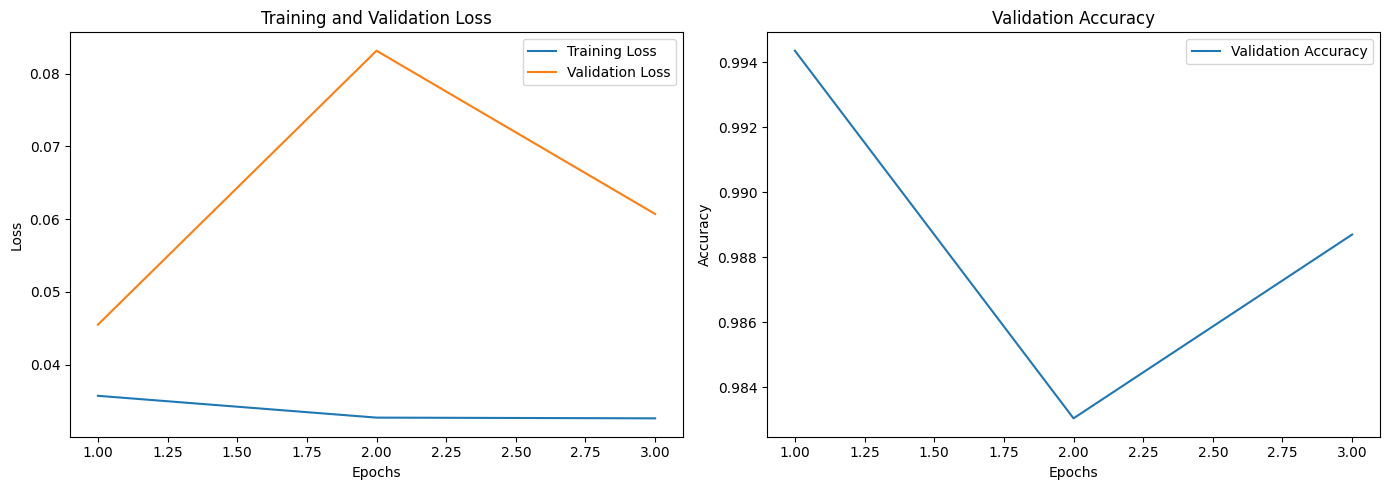

In [58]:
# Initialize lists to store accuracy and loss values
train_loss = []
val_accuracy = []
val_loss = []

# Filter epoch-level logs from trainer.state.log_history
for log in trainer.state.log_history:
    if 'loss' in log and 'epoch' in log:
        train_loss.append(log['loss'])
    if 'eval_loss' in log and 'eval_accuracy' in log:
        val_loss.append(log['eval_loss'])
        val_accuracy.append(log['eval_accuracy'])

# Plot using the available epochs for which we have both training and validation logs
epochs = range(1, len(val_loss) + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss[:len(epochs)], label="Training Loss")  # Match to length of available validation data
plt.plot(epochs, val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracy, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
trainer.save_model()

In [26]:

trainer.log_metrics("train", train_results.metrics)



***** train metrics *****
  epoch                    =         3.0
  total_flos               = 304418682GF
  train_loss               =      0.1547
  train_runtime            =  0:53:02.33
  train_samples_per_second =       1.325
  train_steps_per_second   =       0.083


## Save current state of the Trainer instance

In [27]:
trainer.save_state()

## Model Testing

### Draw Confusion Matrix of model Testing Results

In [28]:
test_dataloader = DataLoader(prepared_ds['test'], batch_size=16)
predictions = []
labels = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation during inference
    for batch in test_dataloader:
        outputs = model(**batch)  # Get model outputs
        predicted_labels = outputs.logits.argmax(-1)  # Get predicted class labels
        predictions.extend(predicted_labels.cpu().numpy())  # Store predictions
        labels.extend(batch['labels'].cpu().numpy())  # Store true labels

cm = confusion_matrix(labels, predictions)
print(cm)

[[42  1  0  0]
 [ 2 41  0  0]
 [ 0  0 42  0]
 [ 0  0  0 43]]


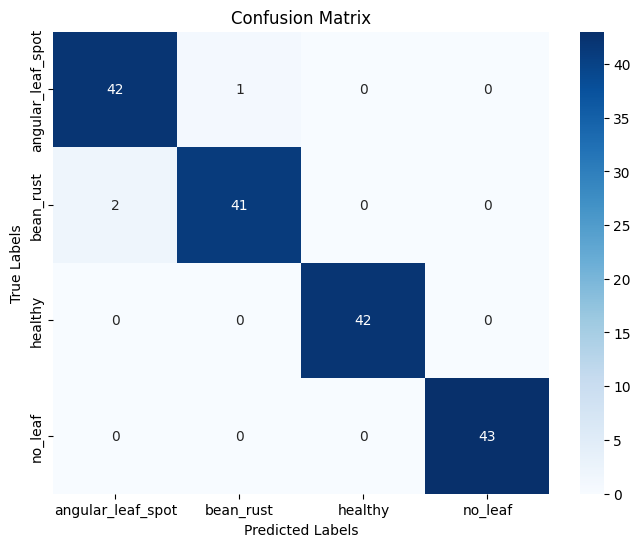

In [59]:
# Draw Confusssion Matrix
class_names = train_ds.classes

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [32]:
# Print Accuracy
accuracy = accuracy_score(labels, predictions)
precision = precision_score(labels, predictions, average='weighted')  # Use weighted average for multi-class
f1 = f1_score(labels, predictions, average='weighted')  # Use weighted average for multi-class
data = {'Metric': ['Accuracy', 'Precision', 'F1 Score'],
        'Score': [accuracy, precision, f1]}
df = pd.DataFrame(data)
print(df.to_string(index=False))  # Display table without inde





   Metric    Score
 Accuracy 0.982456
Precision 0.982583
 F1 Score 0.982454
